# Text Classification Model

โมเดลการจำแนกประเภทข้อความ เพื่อจำแนกและคัดกรองปัญหาสุขภาพจิตของผู้ใช้

In [1]:
import pandas as pd
import numpy as np
from pythainlp import word_tokenize
from tqdm import tqdm_notebook
import re
import emoji
from plotnine import *
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.ensemble import StackingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import ComplementNB
import time
import joblib
from sklearn.metrics import make_scorer, precision_score
from datasets import load_dataset
from sklearn.preprocessing import LabelEncoder
from mlxtend.classifier import StackingClassifier
import itertools
from sklearn.svm import SVC
from xgboost import XGBClassifier

/Users/lapislux/opt/anaconda3/envs/tf/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.0


# Preprocessing data

ใช้ Library Hugging face ดึงข้อมูล

In [2]:
# โหลดข้อมูลจาก Hugging Face
hf_token = "Access_dts_r"
dataset_name = "BBNz/CNC_1"

train_dataset = load_dataset(dataset_name, split='train', use_auth_token=hf_token)
test_dataset = load_dataset(dataset_name, split='test', use_auth_token=hf_token)

train_df = pd.DataFrame(train_dataset)
test_df = pd.DataFrame(test_dataset)
#train_df
test_df

/Users/lapislux/opt/anaconda3/envs/tf/lib/python3.10/site-packages/datasets/load.py:2516: FutureWarning: 'use_auth_token' was deprecated in favor of 'token' in version 2.14.0 and will be removed in 3.0.0.
You can remove this warning by passing 'token=<use_auth_token>' instead.
Using the latest cached version of the dataset since BBNz/CNC_1 couldn't be found on the Hugging Face Hub
Found the latest cached dataset configuration 'default' at /Users/lapislux/.cache/huggingface/datasets/BBNz___CNC_1/default/0.0.0/dde3de98a6ffe06c2ba83ea32eadeb23df5b3d93 (last modified on Sun Mar 31 12:40:00 2024).
Using the latest cached version of the dataset since BBNz/CNC_1 couldn't be found on the Hugging Face Hub
Found the latest cached dataset configuration 'default' at /Users/lapislux/.cache/huggingface/datasets/BBNz___CNC_1/default/0.0.0/dde3de98a6ffe06c2ba83ea32eadeb23df5b3d93 (last modified on Sun Mar 31 12:40:00 2024).


,text,Target
0,ตอนนี้ดูแลพ่อแม่อยู่ ซึ่งบางทีก็ทำไม่ถูกใจท่าน...,guilt
1,รู้สึกว่าตอนที่ไปทำกิจกรรมเราไม่เป็นที่ยอมรับข...,adl
2,พอเวลาจะทำงาน เหมือนมีพลังจะทำงานแค่แปปเดียว แ...,adl
3,ที่บ้านมีร้านค้า ที่ต้องหยุดทำงานเลยเพราะต้องอ...,adl
4,เรื่องานเรียนจบวิศวะมา แต่เลือกมาทำงานคลังสินค...,guilt
...,...,...
95,บางครั้งก็รู้สึกมีความสุขมากกับสิ่งที่กำลังทำ ...,adl
96,มันรู้สึกไม่กระปรี้กระเปร่า ไม่กระตือรือร้น อย...,adl
97,ยังดีไม่พอสำหรับการทำงานที่มีหัวหน้าคอยมองและจ...,adl
98,ทำกิจกรรมเร็วหรือตื่นเต้นมากหัวใจจะสั่นและหอบเ...,adl


In [3]:
#มีคำผิดในชุดข้อมูลอยู่บ้างแต่การรันเพื่อแก้คำผิดใช้เวลานานและใช้ทรัพยากรเยอะเลยละไว้ก่อน
#from pythainlp.spell import correct

# ฟังก์ชันสำหรับการแก้ไขคำผิดในแต่ละแถวของข้อมูล
#def correct_text(text):
#    return correct(text)

# แก้ไขคำผิดในคอลัมน์ 'text'
#train_df['text'] = train_df['text'].apply(correct_text)
#train_df

In [4]:
#Missing Value
#train_df.dropna()
#test_df.dropna()

In [5]:
#Imbalance Data set 
#train_df.target.value_counts()/train_df.shape[0]
#test_df.target.value_counts()/test_df.shape[0]

<Axes: >

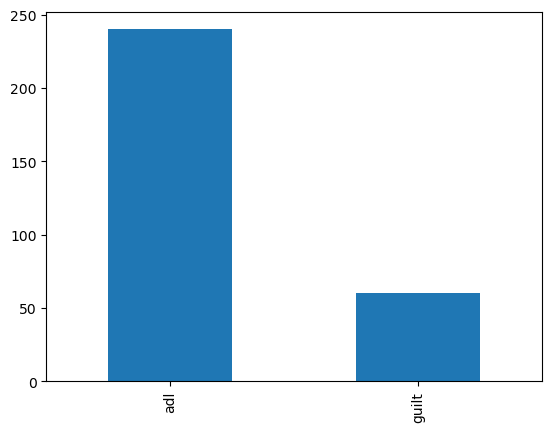

In [6]:
train_df.Target.value_counts().plot(kind="bar")

<Axes: >

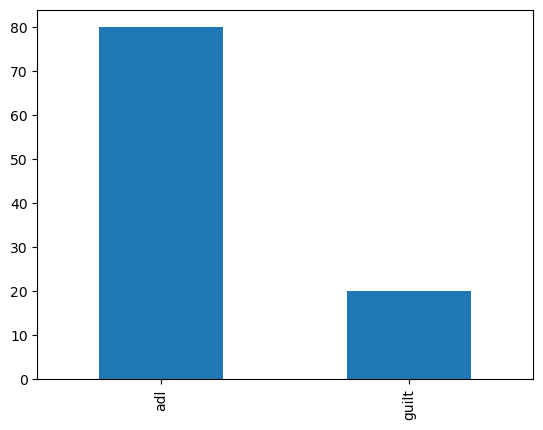

In [7]:
test_df.Target.value_counts().plot(kind="bar")

ทำ Embedding โดยการทำปรับข้อมูล Text เป็น Vector ด้วยวิธี Word2Vec

In [8]:
#Preprocess text
def preprocess_text(text):
    text = emoji.demojize(text)
    text = re.sub(r'\s+', ' ', text)
    text = re.sub(r'[^\w\s]', '', text)
    tokens = word_tokenize(text)
    return tokens

#Tokenize texts
train_df['tokens'] = train_df['text'].apply(preprocess_text)
test_df['tokens'] = test_df['text'].apply(preprocess_text)

In [9]:
from gensim.models import Word2Vec

#Train Word2Vec model on the training data
w2v_model = Word2Vec(sentences=train_df['tokens'], vector_size=300, window=5, min_count=1, workers=4)

In [10]:
#Function to get average Word2Vec embedding
def get_word2vec_embedding(tokens):
    embeddings = [w2v_model.wv[word] for word in tokens if word in w2v_model.wv]
    if embeddings:
        return np.mean(embeddings, axis=0)
    else:
        return np.zeros(w2v_model.vector_size)

In [11]:
# Apply Word2Vec embedding
train_df['embedding'] = train_df['tokens'].apply(get_word2vec_embedding)
test_df['embedding'] = test_df['tokens'].apply(get_word2vec_embedding)

x_train = np.vstack(train_df['embedding'].values)
x_test = np.vstack(test_df['embedding'].values)
y_train = train_df['Target']
y_test = test_df['Target']

In [12]:
# Encode labels as numeric values เพราะบางโมเดลจะคาดหวังว่า Labels จะต้องเป็นตัวเลขเท่านั้น
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)
y_train = y_train_encoded
y_test = y_test_encoded

In [13]:
#เพราะชุดข้อมูลมีความไบแอสมากและเป็นชุดข้อมูลที่เกี่ยวข้องกับการแพทย์จึงให้ความสำคัญ
#กับการทำนายหา TP ที่วัดได้จากค่า Precision จึงมีความพยายามทำชุดข้อมูลให้เท่ากันและเยอะขึ้นเพื่อลด
#ความไบแอสของโมเดล แน่นอนว่าการใช้ RandomOverSample เองก็ไม่สามารถทำให้ได้ข้อมูลที่มีคุณภาพมากพอ 
#เมื่อเทียบกับการใช้ ML สร้างข้อความที่ใกล้เคียงกัน แต่มันใช้ทรัพยากรและเวลามากจึงใช้เพียง OverSample
#คุณสามารถใช้วิธี Paraphrasing, Synonym Replacement หรือ การสร้างข้อความด้วย AI เช่น GPT เพื่อเพิ่มปประสิทธิภาพของโมเดลได้ถ้ามีเวลาและทรัพยากรมากพอ

from imblearn.over_sampling import RandomOverSampler

# Apply RandomOverSampler
ros = RandomOverSampler(random_state=42)
x_train_resampled, y_train_resampled = ros.fit_resample(x_train, y_train)
x_train = x_train_resampled
y_train = y_train_resampled

# Modeling

In [14]:
#Fine Best Parameters and Hyperparameters ของแต่ละโมเดลที่เหทากะกับ Word2vecและปัญหา Text Classification เพื่อนำไปใช้ต่อกับโมเดล Stacking ต่อไป
#เพราะ Stacking Models มีประสิทธิภาพค่อนข้างดีในการแก้ปัญหาประเภท Text Classification
#การตั้งค่าด้านล่างมีเพอร์ฟอร์มที่ไม่ดีนัก เฉลี่ยน Precision ในคลาส guilt ประมาณ 0.4 เท่านั้น 
#อย่างไรก็ดี ฉันเคยตั้งค่าที่ละเอียดกว่านี้(หลัก 0.01) จะไ้ค่าเฉลี่ยประมาณ 0.7-0.8 ซึ่งเพียงพอต่อการใช้งาน 
#แต่มันจะใช้เวลานานมากหลักหลาย ชม ฉันลดการตั้งค่าลงเป็นแบบด้านล่างเพื่อรันและทดสอบตัวโปรแกรมใหม่ 
#ดังนั้นคุณสามารถปรับจูนการตั้งค่าเพิ่มเติมเพื่อเพิ่มเพอร์ฟอร์มด้วยตัวเองได้

time_start = time.time()

#----- KNN -----
knn = KNeighborsClassifier()
knn_params = {'n_neighbors': range(1, 100, 2)}

knn_grid = GridSearchCV(estimator=knn, param_grid=knn_params)
knn_grid.fit(x_train, y_train)

print('KNN Best Score:', knn_grid.best_score_)
print('KNN Best Params:', knn_grid.best_params_)
joblib.dump(knn_grid.best_estimator_, 'knn_best_model.pkl')
print()

#----- Random Forest -----
forest = RandomForestClassifier(random_state=0)
forest_params = {
    'n_estimators': range(1, 10, 1),
    'criterion': ['entropy', 'gini'],
}
forest_grid = GridSearchCV(estimator=forest, param_grid=forest_params)
forest_grid.fit(x_train, y_train)

print('Random Forest Best Score:', forest_grid.best_score_)
print('Random Forest Best Params:', forest_grid.best_params_)
joblib.dump(forest_grid.best_estimator_, 'forest_best_model.pkl')
print()


#-----LinearSVC-----
LSVC = LinearSVC(max_iter=100000)
LSVC_params = {
    'C': np.arange(0.1, 100, 0.1),
    
}

LSVC_grid = GridSearchCV(estimator=LSVC, param_grid=LSVC_params)
LSVC_grid.fit(x_train, y_train)

print('LinearSVC Best Score:', LSVC_grid.best_score_)
print('LinearSVC Best Params:', LSVC_grid.best_params_)
joblib.dump(LSVC_grid.best_estimator_, 'lsvc_best_model.pkl')
print()

#-----LogisticRegression-----
LR = LogisticRegression()
LR_params = {
    'C': np.arange(0.1, 100, 0.1),
    # 'penalty': ['l1', 'l2','elasticnet']
}

LR_grid = GridSearchCV(estimator=LR, param_grid=LR_params)
LR_grid.fit(x_train, y_train)

print('LogisticRegression Best Score:', LR_grid.best_score_)
print('LogisticRegression Best Params:', LR_grid.best_params_)
joblib.dump(LR_grid.best_estimator_, 'lr_best_model.pkl')
print()

#----- SVM -----
svm = SVC()
svm_params = {'C': [0.1, 1, 10, 100], 'kernel': ['linear', 'rbf']}

svm_grid = GridSearchCV(estimator=svm, param_grid=svm_params, cv=3, n_jobs=-1, verbose=2)
svm_grid.fit(x_train, y_train)

print('SVM Best Score:', svm_grid.best_score_)
print('SVM Best Params:', svm_grid.best_params_)
joblib.dump(svm_grid.best_estimator_, 'svm_best_model.pkl')
print()

#----- XGBoost -----
xgb = XGBClassifier(eval_metric='mlogloss')
xgb_params = {
    'n_estimators': [100, 200],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}

xgb_grid = GridSearchCV(estimator=xgb, param_grid=xgb_params, cv=3, n_jobs=-1, verbose=2)
xgb_grid.fit(x_train, y_train)
print('XGBoost Best Score:', xgb_grid.best_score_)
print('XGBoost Best Params:', xgb_grid.best_params_)
joblib.dump(xgb_grid.best_estimator_, 'xgb_best_model.pkl')

time_end = time.time()
print(f'Total Time: {time_end - time_start} - Second')


KNN Best Score: 0.8958333333333334
KNN Best Params: {'n_neighbors': 1}

Random Forest Best Score: 0.95625
Random Forest Best Params: {'criterion': 'entropy', 'n_estimators': 10}

LinearSVC Best Score: 0.675
LinearSVC Best Params: {'C': 94.1}

LogisticRegression Best Score: 0.5541666666666667
LogisticRegression Best Params: {'C': 97.8}

Fitting 3 folds for each of 8 candidates, totalling 24 fits


/Users/lapislux/opt/anaconda3/envs/tf/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.0
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/Users/lapislux/opt/anaconda3/envs/tf/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.0
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/Users/lapislux/opt/anaconda3/envs/tf/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.0
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/Users/lapislux/opt/anaconda3/envs/tf/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version 

SVM Best Score: 0.5437500000000001
SVM Best Params: {'C': 100, 'kernel': 'linear'}

Fitting 3 folds for each of 72 candidates, totalling 216 fits
XGBoost Best Score: 0.9104166666666668
XGBoost Best Params: {'colsample_bytree': 0.8, 'learning_rate': 0.2, 'max_depth': 5, 'n_estimators': 200, 'subsample': 0.8}
Total Time: 11381.384966135025 - Second


In [20]:
print("--------------------------- KNN ---------------------------")
knn_best_model = joblib.load('knn_best_model.pkl')
knn_best_model.fit(x_train,y_train)
knn_best_model.score(x_train,y_train)
test_pred = knn_best_model.predict(x_test)
test_pred = label_encoder.inverse_transform(test_pred)
print(classification_report(test_df['Target'], test_pred))


print("--------------------- Random Forest -----------------------")
forest_best_model = joblib.load('forest_best_model.pkl')
forest_best_model.fit(x_train,y_train)
forest_best_model.score(x_train,y_train)
test_pred = forest_best_model.predict(x_test)
test_pred = label_encoder.inverse_transform(test_pred)
print(classification_report(test_df['Target'], test_pred))


print("----------------------- LinearSVC -------------------------")
lsvc_best_model = joblib.load('lsvc_best_model.pkl')
lsvc_best_model.fit(x_train,y_train)
lsvc_best_model.score(x_train,y_train)
test_pred = lsvc_best_model.predict(x_test)
test_pred = label_encoder.inverse_transform(test_pred)
print(classification_report(test_df['Target'], test_pred))


print("------------------- LogisticRegression ---------------------")
lr_best_model = joblib.load('lr_best_model.pkl')
lr_best_model.fit(x_train,y_train)
lr_best_model.score(x_train,y_train)
test_pred = lr_best_model.predict(x_test)
test_pred = label_encoder.inverse_transform(test_pred)
print(classification_report(test_df['Target'], test_pred))


print("-------------------------- SVM ----------------------------")
svm_best_model = joblib.load('svm_best_model.pkl')
svm_best_model.fit(x_train,y_train)
svm_best_model.score(x_train,y_train)
test_pred = svm_best_model.predict(x_test)
test_pred = label_encoder.inverse_transform(test_pred)
print(classification_report(test_df['Target'], test_pred))


print("-------------------------- XGBoost -------------------------")
xgb_best_model = joblib.load('xgb_best_model.pkl')
xgb_best_model.fit(x_train,y_train)
xgb_best_model.score(x_train,y_train)
test_pred = xgb_best_model.predict(x_test)
test_pred = label_encoder.inverse_transform(test_pred)
print(classification_report(test_df['Target'], test_pred))


--------------------------- KNN ---------------------------
              precision    recall  f1-score   support

         adl       0.82      0.91      0.86        80
       guilt       0.36      0.20      0.26        20

    accuracy                           0.77       100
   macro avg       0.59      0.56      0.56       100
weighted avg       0.73      0.77      0.74       100

--------------------- Random Forest -----------------------
              precision    recall  f1-score   support

         adl       0.82      0.94      0.88        80
       guilt       0.44      0.20      0.28        20

    accuracy                           0.79       100
   macro avg       0.63      0.57      0.58       100
weighted avg       0.75      0.79      0.76       100

----------------------- LinearSVC -------------------------
              precision    recall  f1-score   support

         adl       0.89      0.80      0.84        80
       guilt       0.43      0.60      0.50        20

  

In [16]:
# สร้าง list ของโมเดลที่ดีที่สุด
all_best_models = [knn_best_model, forest_best_model,svm_best_model,xgb_best_model, lsvc_best_model, lr_best_model]

In [17]:
# Stacking Classifier
best_stack_model = None
best_stack_score = 0
for L in range(2, len(all_best_models)+1):
    for subset in itertools.combinations(all_best_models, L):
        stack_model = StackingClassifier(classifiers=list(subset), meta_classifier=LogisticRegression())
        stack_model.fit(x_train, y_train)
        y_pred = stack_model.predict(x_test)
        precision = precision_score(y_test, y_pred, average='weighted')
        if precision > best_stack_score:
            best_stack_score = precision
            best_stack_model = stack_model
        print(f'ทดสอบ Stacking Model กับ {L} โมเดล - Precision: {precision}')

# ประเมินผลโมเดลที่ดีที่สุด
y_pred = best_stack_model.predict(x_test)
y_pred_labels = label_encoder.inverse_transform(y_pred)
y_val_labels = label_encoder.inverse_transform(y_test)
print("Confusion Matrix ของโมเดล Stacking ที่ดีที่สุด:\n", confusion_matrix(y_val_labels, y_pred_labels))
print("รายงานการจำแนกของโมเดล Stacking ที่ดีที่สุด:\n", classification_report(y_val_labels, y_pred_labels))

# บันทึกโมเดลที่ดีที่สุดและตัวเข้ารหัส labels
joblib.dump(best_stack_model, 'best_stack_model.pkl')
joblib.dump(w2v_model, 'word2vec_model.pkl')
joblib.dump(label_encoder, 'label_encoder.pkl')

ทดสอบ Stacking Model กับ 2 โมเดล - Precision: 0.7289070480081716
ทดสอบ Stacking Model กับ 2 โมเดล - Precision: 0.7289070480081716
ทดสอบ Stacking Model กับ 2 โมเดล - Precision: 0.7784549964564138
ทดสอบ Stacking Model กับ 2 โมเดล - Precision: 0.7289070480081716
ทดสอบ Stacking Model กับ 2 โมเดล - Precision: 0.7289070480081716
ทดสอบ Stacking Model กับ 2 โมเดล - Precision: 0.7482295482295481
ทดสอบ Stacking Model กับ 2 โมเดล - Precision: 0.7766513056835638
ทดสอบ Stacking Model กับ 2 โมเดล - Precision: 0.7482295482295481
ทดสอบ Stacking Model กับ 2 โมเดล - Precision: 0.7482295482295481
ทดสอบ Stacking Model กับ 2 โมเดล - Precision: 0.7766513056835638
ทดสอบ Stacking Model กับ 2 โมเดล - Precision: 0.7968253968253969
ทดสอบ Stacking Model กับ 2 โมเดล - Precision: 0.68
ทดสอบ Stacking Model กับ 2 โมเดล - Precision: 0.7766513056835638
ทดสอบ Stacking Model กับ 2 โมเดล - Precision: 0.7766513056835638
ทดสอบ Stacking Model กับ 2 โมเดล - Precision: 0.7968253968253969
ทดสอบ Stacking Model กับ 3 โมเดล - Prec

['label_encoder.pkl']

# API

In [18]:
#ฉันเลือกใช้การทำและสร้าง API เพื่อรันบน LocalHost ด้วยเหตุผลเรื่องคามสะดวกส่วนตัว
#คัว API จะทำนายผลจากอินพุตที่ได้รับแล้วแรนด์ด้อมค่าจากผลทำนายเพื่อส่งออก

from flask import Flask, request, jsonify
import joblib
from gensim.models import Word2Vec
import numpy as np
from pythainlp import word_tokenize
import re
import emoji
import random
import threading
from pyngrok import ngrok

app = Flask(__name__)

# Load the models
stacking_model = joblib.load('best_stack_model.pkl')
w2v_model = joblib.load('word2vec_model.pkl')
label_encoder = joblib.load('label_encoder.pkl')

statements_for_case_1 = [
    "ผมรู้สึกว่าคุณกำลังมีความรู้สึกหนักใจหรือกังวลใจบางอย่าง และผมเป็นห่วงคุณมาก การทำแบบทดสอบสุขภาพจิตอาจช่วยให้คุณเข้าใจสถานการณ์ของตัวเองมากขึ้นครับ",
    "ผมเห็นว่าคุณมีความรู้สึกผิดหรือกังวลใจมากเป็นพิเศษ การทำแบบทดสอบสุขภาพจิตอาจเป็นวิธีที่ดีที่จะช่วยคุณค้นหาวิธีการจัดการกับความรู้สึกเหล่านี้ครับ",
    "จากที่เราได้คุยกัน ผมรู้สึกว่าคุณกำลังเผชิญกับความรู้สึกที่ยากลำบาก การทำแบบทดสอบสุขภาพจิตอาจช่วยให้คุณได้รับคำแนะนำที่เหมาะสมครับ",
    "ความรู้สึกที่คุณเล่าให้ฟังดูเหมือนจะเป็นสิ่งที่ทำให้คุณเครียดมาก ผมอยากแนะนำให้คุณลองทำแบบทดสอบสุขภาพจิตเพื่อหาวิธีช่วยเหลือครับ",
    "ผมรู้สึกว่าคุณมีความกังวลใจมาก การทำแบบทดสอบสุขภาพจิตอาจช่วยให้คุณได้เห็นภาพรวมของสุขภาพจิตของตัวเองและหาวิธีจัดการกับมันครับ",
    "ผมรู้สึกว่าคุณอาจต้องการการสนับสนุนเพิ่มเติม การทำแบบทดสอบสุขภาพจิตอาจช่วยให้คุณได้รับคำแนะนำที่มีประโยชน์มากขึ้นครับ",
    "ผมเป็นห่วงความรู้สึกของคุณครับ การทำแบบทดสอบสุขภาพจิตอาจเป็นขั้นตอนแรกที่ดีที่จะช่วยให้คุณได้รับการช่วยเหลือที่ถูกต้องครับ",
    "ความรู้สึกที่คุณเล่าให้ฟังทำให้ผมกังวลใจครับ ผมคิดว่าการทำแบบทดสอบสุขภาพจิตอาจช่วยให้คุณได้รับการสนับสนุนที่เหมาะสมครับ",
    "ผมรู้ว่าคุณกำลังผ่านช่วงเวลาที่ยากลำบากครับ การทำแบบทดสอบสุขภาพจิตอาจช่วยให้คุณได้รับคำแนะนำที่เป็นประโยชน์และช่วยให้คุณรู้สึกดีขึ้นครับ",
    "ผมเห็นว่าคุณกำลังเผชิญกับความกังวลใจมาก ผมอยากแนะนำให้คุณลองทำแบบทดสอบสุขภาพจิตครับ มันอาจเป็นเครื่องมือที่มีประโยชน์ในการช่วยคุณจัดการกับความรู้สึกเหล่านี้ครับ"
]

statements_for_case_2 = [
    "ผมเข้าใจว่าคุณกำลังเผชิญกับเรื่องที่ยากลำบากอยู่ และผมอยากให้คุณรู้ว่าผมอยู่ที่นี่เพื่อรับฟังและสนับสนุนคุณครับ",
    "ผมเห็นว่าคุณกำลังมีความกังวลใจ และผมอยากให้คุณรู้ว่าความรู้สึกเหล่านี้เป็นเรื่องปกติ ไม่ต้องกังวลเกินไปครับ",
    "หากคุณรู้สึกว่าต้องการพูดคุยหรือแชร์ความรู้สึก ผมพร้อมรับฟังเสมอครับ คุณไม่ได้อยู่คนเดียวในเรื่องนี้",
    "การได้พูดคุยและแชร์ความรู้สึกบางครั้งอาจช่วยให้คุณรู้สึกดีขึ้น ผมอยู่ที่นี่เพื่อฟังคุณครับ",
    "ผมเข้าใจว่าคุณกำลังผ่านช่วงเวลาที่ไม่ง่าย ผมอยากให้คุณรู้ว่าผมเป็นห่วงและอยู่ที่นี่เพื่อสนับสนุนคุณครับ",
    "ถ้าคุณรู้สึกว่าต้องการการสนับสนุนเพิ่มเติม อย่าลังเลที่จะบอกผมนะครับ ผมอยู่ที่นี่เพื่อช่วยเหลือคุณ",
    "คุณกำลังเผชิญกับความยากลำบากและผมเข้าใจ ผมอยู่ที่นี่เพื่อให้กำลังใจและรับฟังความรู้สึกของคุณครับ",
    "ผมอยากให้คุณรู้ว่าคุณไม่ได้อยู่คนเดียวครับ ทุกคนมีวันที่ไม่ดี และผมอยู่ที่นี่เพื่อช่วยคุณผ่านมันไป",
    "ผมเห็นว่าคุณกำลังรู้สึกไม่สบายใจ ผมอยากให้คุณรู้ว่าความรู้สึกเหล่านี้เป็นเรื่องธรรมดา และผมพร้อมอยู่เคียงข้างคุณเสมอ",
    "ถ้าคุณรู้สึกว่าต้องการใครสักคนรับฟัง ผมพร้อมเสมอครับ บางครั้งการได้พูดออกมาก็ช่วยให้เรารู้สึกเบาใจขึ้น"
]

def preprocess_text(text):
    text = emoji.demojize(text)
    text = re.sub(r'\s+', ' ', text)
    text = re.sub(r'[^\w\s]', '', text)
    tokens = word_tokenize(text)
    return tokens

def get_word2vec_embedding(tokens):
    embeddings = [w2v_model.wv[word] for word in tokens if word in w2v_model.wv]
    if embeddings:
        return np.mean(embeddings, axis=0)
    else:
        return np.zeros(w2v_model.vector_size)

class Predict:
    @app.route('/predict', methods=['POST'])
    def post():
        data = request.get_json(force=True)
        message = data['message']
        
        tokens = preprocess_text(message)
        features = get_word2vec_embedding(tokens).reshape(1, -1)
        
        if features is None or len(features) == 0:
            return jsonify({
                'error': 'Could not process the input text.'
            }), 400
        
        prediction = stacking_model.predict(features)
        prediction_label = label_encoder.inverse_transform(prediction)[0]
        
        if prediction_label == 'guilt':
            response_message = random.choice(statements_for_case_1) + " คุณสามารถทำการทดสอบได้ที่นี่ " + "https://checkin.dmh.go.th/main/index.php?type=1"
        elif prediction_label == 'adl':
            response_message = random.choice(statements_for_case_2) + " ไม่ต้องกังวลไป! คุณจะสามารถผ่านมันไปได้! และไม่มีความเสี่ยง จนถึงขั้นต้องทำแบบทดสอบ"
        else:
            response_message = "ไม่พบประเภทที่ตรงกับข้อมูลที่ระบุ"
        
        return jsonify({
            'prediction': prediction_label,
            'message': response_message
        })

def run_app():
    app.run(port=9000, debug=True, use_reloader=False)

if __name__ == "__main__":
    # รัน Flask API ใน thread แยก
    thread = threading.Thread(target=run_app)
    thread.start()

 * Serving Flask app '__main__'
 * Debug mode: on
